# Cython, que no CPython

No, no nos hemos equivocado en el título, hoy vamos a hablar de Cython.

¿Qué es Cython?

Cython son dos cosas:

* Por una parte, Cython es un lenguaje de programación (un superconjunto de Python) que une Python con el sistema de tipado estático de C y C++.
* Por otra parte, `cython` es un compilador que traduce codigo fuente escrito en Cython en eficiente código C o C++. El código resultante se podría usar como una extensión Python o como un ejecutable.

¡Guau! ¿Cómo os habéis quedado?

Lo que se pretende es, básicamente, aprovechar las fortalezas de Python y C, combinar una sintaxis sencilla con el poder y la velocidad.

Salvando algunas excepciones, el código Python (tanto Python 2 como Python 3) es código Cython válido. Además, Cython añade una serie de palabras clave para poder usar el sistema de tipado de C con Python y que el compilador `cython` pueda generar código C eficiente.

Pero, ¿quién usa Cython?

Pues mira, igual no lo sabes pero seguramente estés usando Cython todos los días. Sage tiene casi medio millón de líneas de Cython (que se dice pronto), Scipy y Pandas más de 20000, scikit-learn unas 15000,...

# ¿Nos empezamos a meter en harina?

La idea principal de este primer acercamiento a Cython será empezar con un código Python que sea nuestro cuello de botella e iremos creando versiones que sean cada vez más rápidas, o eso intentaremos.

Por ejemplo, imaginemos que tenemos que detectar valores mínimos locales dentro de una malla. Los valores mínimos deberán ser simplemente valores más bajos que los que haya en los 8 nodos de su entorno inmediato. En el siguiente gráfico, el nodo en verde será un nodo con un mínimo y en su entorno son todo valores superiores:

<table>
 <tr>
  <td style="background:red">(2, 0)</td>
  <td style="background:red">(2, 1)</td>
  <td style="background:red">(2, 2)</td>
 </tr>
 <tr>
  <td style="background:red">(1, 0)</td>
  <td style="background:green">(1. 1)</td>
  <td style="background:red">(1, 2)</td>
 </tr>
 <tr>
  <td style="background:red">(0, 0)</td>
  <td style="background:red">(0, 1)</td>
  <td style="background:red">(0, 2)</td>
 </tr>
</table>

# Setup

Como siempre, importamos algunas librerías antes de empezar a picar código:

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Creamos una matriz cuadrada relativamente grande (4 millones de elementos).

In [13]:
np.random.seed(0)
data = np.random.randn(2000, 2000)

Ya tenemos los datos listos para empezar a trabajar. 

Vamos a crear una función en Python que busque los mínimos tal como los hemos definido.

In [14]:
def busca_min(malla):
    minimosx = []
    minimosy = []
    for i in range(1, malla.shape[1]-1):
        for j in range(1, malla.shape[0]-1):
            if (malla[j, i] < malla[j-1, i-1] and
                malla[j, i] < malla[j-1, i] and
                malla[j, i] < malla[j-1, i+1] and
                malla[j, i] < malla[j, i-1] and
                malla[j, i] < malla[j, i+1] and
                malla[j, i] < malla[j+1, i-1] and
                malla[j, i] < malla[j+1, i] and
                malla[j, i] < malla[j+1, i+1]):
                minimosx.append(i)
                minimosy.append(j)

    return np.array(minimosx), np.array(minimosy)

Veamos cuanto tarda esta función en mi máquina:

In [15]:
%timeit busca_min(data)

1 loops, best of 3: 4.24 s per loop


Buff, tres segundos y pico en un i7... Si tengo que buscar los mínimos en 500 de estos casos me va a tardar casi media hora.

Por casualidad, vamos a probar numba a ver si es capaz de resolver el problema sin mucho esfuerzo, es código Python muy sencillo en el cual no usamos cosas muy 'extrañas' del lenguaje.

In [16]:
from numba import jit

@jit
def busca_min_numba(malla):
    minimosx = []
    minimosy = []
    for i in range(1, malla.shape[1]-1):
        for j in range(1, malla.shape[0]-1):
            if (malla[j, i] < malla[j-1, i-1] and
                malla[j, i] < malla[j-1, i] and
                malla[j, i] < malla[j-1, i+1] and
                malla[j, i] < malla[j, i-1] and
                malla[j, i] < malla[j, i+1] and
                malla[j, i] < malla[j+1, i-1] and
                malla[j, i] < malla[j+1, i] and
                malla[j, i] < malla[j+1, i+1]):
                minimosx.append(i)
                minimosy.append(j)

    return np.array(minimosx), np.array(minimosy)

In [17]:
%timeit busca_min_numba(data)

1 loops, best of 3: 5.28 s per loop


Ooooops! Parece que la magia de numba no funciona aquí.

Vamos a especificar los tipos de entrada y de salida (y a modificar el output) a ver si mejora algo:

In [18]:
from numba import jit
from numba import int32, float64

@jit(int32[:,:](float64[:,:]))
def busca_min_numba(malla):
    minimosx = []
    minimosy = []
    for i in range(1, malla.shape[1]-1):
        for j in range(1, malla.shape[0]-1):
            if (malla[j, i] < malla[j-1, i-1] and
                malla[j, i] < malla[j-1, i] and
                malla[j, i] < malla[j-1, i+1] and
                malla[j, i] < malla[j, i-1] and
                malla[j, i] < malla[j, i+1] and
                malla[j, i] < malla[j+1, i-1] and
                malla[j, i] < malla[j+1, i] and
                malla[j, i] < malla[j+1, i+1]):
                minimosx.append(i)
                minimosy.append(j)

    return np.array([minimosx, minimosy], dtype = np.int32)

In [19]:
%timeit busca_min_numba(data)

1 loops, best of 3: 5.33 s per loop


Pues parece que no, el resultado es del mismo pelo. Usando la opción `nopython` me casca un error un poco feo,... 

Habrá que seguir esperando a que numba esté un poco más maduro. En mis pocas experiencias no he conseguido aun el efecto que buscaba y en la mayoría de los casos obtengo errores muy crípticos. No es que no tenga confianza en la gente que está detrás, solo estoy diciendo que aun no está listo para 'producción'. Esto no pretende ser una guerra Cython/numba, solo he usado numba para ver si a pelo era capaz de mejorar algo el tema. Como no ha sido así, nos olvidamos de numba de momento.

# Cythonizando, que es gerundio (toma 1).

Lo más sencillo y evidente es usar directamente el compilador `cython` y ver si usando el código python tal cual es un poco más rápido. Para ello, vamos a usar las funciones mágicas que Cython pone a nuestra disposición  en el notebook. Solo vamos a hablar de la función máfica `%%cython` de momento, aunque hay otras.

In [20]:
# antes cythonmagic
%load_ext Cython

EL comando `%%cython` nos permite escribir código Cython en una celda. Una vez que ejecutamos la celda, IPython se encarga de coger el código, crear un fichero de código Cython con extensión *.pyx*, compilarlo a C y, si todo está correcto, importar ese fichero para que todo esté disponible dentro del notebook.

[INCISO] a la función mágica `%%cython` le podemos pasar una serie de argumentos. Veremos alguno en este tutorial pero ahora vamos a definir uno que sirve para que podamos nombrar a la funcíon que se crea y compila al vuelo, `-n` o `--name`.

In [21]:
%%cython --name probandocython1
import numpy as np

def busca_min_cython1(malla):
    minimosx = []
    minimosy = []
    for i in range(1, malla.shape[1]-1):
        for j in range(1, malla.shape[0]-1):
            if (malla[j, i] < malla[j-1, i-1] and
                malla[j, i] < malla[j-1, i] and
                malla[j, i] < malla[j-1, i+1] and
                malla[j, i] < malla[j, i-1] and
                malla[j, i] < malla[j, i+1] and
                malla[j, i] < malla[j+1, i-1] and
                malla[j, i] < malla[j+1, i] and
                malla[j, i] < malla[j+1, i+1]):
                minimosx.append(i)
                minimosy.append(j)

    return np.array(minimosx), np.array(minimosy)

El fichero se creará dentro de la carpeta *cython* disponible dentro del directorio resultado de la función `get_ipython_cache_dir`. Veamos la localización del fichero en mi equipo:

In [22]:
from IPython.utils.path import get_ipython_cache_dir

In [23]:
print(get_ipython_cache_dir() + '/cython/probandocython1.c')

/home/kiko/.cache/ipython/cython/probandocython1.c


No lo muestro por aquí porque el resultado son más de ¡¡2400!! líneas de código C.

Veamos ahora lo que tarda.

In [24]:
%timeit busca_min_cython1(data)

1 loops, best of 3: 3.4 s per loop


Bueno, parece que sin hacer mucho esfuerzo hemos conseguido ganar en torno a un 5%-25% de rendimiento (dependerá del caso). No es gran cosa pero Cython es capaz de mucho más...

# Cythonizando, que es gerundio (toma 2).

En esta parte vamos a introducir una de las palabras clave que Cython introduce para extender Python, `cdef`. La palabra clave `cdef` sirve para 'tipar' estáticamente variables en Cython (luego veremos que se usa también para definir funciones). Por ejemplo:

```Python
cdef int var1, var2
cdef float var3
```

En el bloque de código de más arriba he creado dos variables de tipo entero, `var1` y `var2`, y una variable de tipo float, `var3`. Los [tipos anteriores son la nomenclatura C](http://docs.cython.org/src/userguide/language_basics.html#automatic-type-conversions).

Vamos a intentar usar `cdef` con algunos tipos de datos que tenemos dentro de nuestra función. Para empezar, veo evidente que tengo varias listas (`minimosx` y `minimosy`), tenemos los índices de los bucles (`i` y `j`) y voy a convertir los parámetros de los `range` en tipos estáticos (`ii` y `jj`):

In [25]:
%%cython --name probandocython2
import numpy as np

def busca_min_cython2(malla):
    cdef list minimosx, minimosy
    cdef unsigned int i, j
    cdef unsigned int ii = malla.shape[1]-1
    cdef unsigned int jj = malla.shape[0]-1
    minimosx = []
    minimosy = []
    for i in range(1, ii):
        for j in range(1, jj):
            if (malla[j, i] < malla[j-1, i-1] and
                malla[j, i] < malla[j-1, i] and
                malla[j, i] < malla[j-1, i+1] and
                malla[j, i] < malla[j, i-1] and
                malla[j, i] < malla[j, i+1] and
                malla[j, i] < malla[j+1, i-1] and
                malla[j, i] < malla[j+1, i] and
                malla[j, i] < malla[j+1, i+1]):
                minimosx.append(i)
                minimosy.append(j)

    return np.array(minimosx), np.array(minimosy)

In [26]:
%timeit busca_min_cython2(data)

1 loops, best of 3: 3.8 s per loop


Vaya decepción... No hemos conseguido gran cosa, tenemos un código un poco más largo y estamos peor que en la **toma 1**.

En realidad, estamos usando objetos Python como listas (no es un tipo C/C++ puro pero Cython lo declara como puntero a algún tipo `struct` de Python) y no hemos definido las variables de entrada y de salida.

[INCISO] Cuando existe un tipo Python y C que tienen el mismo nombre (por ejemplo, `int`) predomina el de C (porque es lo deseable, ¿no?).

# Cythonizando, que es gerundio (toma 3).

En Cython existen tres tipos de funciones, las definidas en el espacio Python con `def`, las definidas en el espacio C con `cdef` (sí, lo mismo que usamos para declarar los tipos) y las definidas en ambos espacios con `cpdef`.

* `def`: ya lo hemos visto y funciona como se espera. Accesible desde Python
* `cdef`: No es accesible desde Python y la tendremos que envolver con una función Python para poder acceder a la misma.
* `cpdef`: Es accesible tanto desde Python como desde C y Cython se encargará de hacer el 'envoltorio' para nosotros. Esto meterá un poco más de código y empeorará levemente el rendimiento.

Si definimos una función con `cdef` debería ser una función que se usa internamente dentro del módulo Cython que vayamos a crear y que no sea necesario llamar desde Python.

Veamos un ejemplo de lo dicho anteriormente definiendo la salida de la función como tupla:

In [27]:
%%cython --name probandocython3
import numpy as np

cdef tuple cbusca_min_cython3(malla):
    cdef list minimosx, minimosy
    cdef unsigned int i, j
    cdef unsigned int ii = malla.shape[1]-1
    cdef unsigned int jj = malla.shape[0]-1
    cdef unsigned int start = 1
    minimosx = []
    minimosy = []
    for i in range(start, ii):
        for j in range(start, jj):
            if (malla[j, i] < malla[j-1, i-1] and
                malla[j, i] < malla[j-1, i] and
                malla[j, i] < malla[j-1, i+1] and
                malla[j, i] < malla[j, i-1] and
                malla[j, i] < malla[j, i+1] and
                malla[j, i] < malla[j+1, i-1] and
                malla[j, i] < malla[j+1, i] and
                malla[j, i] < malla[j+1, i+1]):
                minimosx.append(i)
                minimosy.append(j)

    return np.array(minimosx), np.array(minimosy)

def busca_min_cython3(malla):
    return cbusca_min_cython3(malla)

In [28]:
%timeit busca_min_cython3(data)

1 loops, best of 3: 3.8 s per loop


Vaya, seguimos sin estar muy a gusto con estos resultados.

Seguimos sin definir el tipo del valor de entrada.

La función mágica `%%cython` dispone de una serie de funcionalidades entre la que se encuentra `-a` o `--annotate` (además del `-n` o `--name` que ya hemos visto). Si le pasamos este parámetro podremos ver una representación del código con colores marcando las partes más lentas (amarillo más oscuro) y más optmizadas (más claro) o a la velocidad de C (blanco). Vamos a usarlo para saber donde tenemos cuellos de botella (aplicado a nuestra última versión del código):

In [29]:
%%cython --annotate
import numpy as np

cdef tuple cbusca_min_cython3(malla):
    cdef list minimosx, minimosy
    cdef unsigned int i, j
    cdef unsigned int ii = malla.shape[1]-1
    cdef unsigned int jj = malla.shape[0]-1
    cdef unsigned int start = 1
    minimosx = []
    minimosy = []
    for i in range(start, ii):
        for j in range(start, jj):
            if (malla[j, i] < malla[j-1, i-1] and
                malla[j, i] < malla[j-1, i] and
                malla[j, i] < malla[j-1, i+1] and
                malla[j, i] < malla[j, i-1] and
                malla[j, i] < malla[j, i+1] and
                malla[j, i] < malla[j+1, i-1] and
                malla[j, i] < malla[j+1, i] and
                malla[j, i] < malla[j+1, i+1]):
                minimosx.append(i)
                minimosy.append(j)

    return np.array(minimosx), np.array(minimosy)

def busca_min_cython3(malla):
    return cbusca_min_cython3(malla)

El `if` parece la parte más lenta. Estamos usando el valor de entrada que no tiene un tipo Cython definido.

Los bucles parece que están optimizados (las variables envueltas en el bucle las hemos declarado como `unsigned int`).

Pero todas las partes por las que pasa el numpy array parece que no están muy optimizadas...

# Cythonizando, que es gerundio (toma 4).

Ahora mismo, haciendo `import numpy as np` tenemos acceso a la funcionalidad Python de numpy. Para poder acceder a la funcionalidad C de numpy hemos de hacer un `cimport` de numpy.

El `cimport` se usa para importar información especial del módulo numpy en el momento de compilación. Esta información se encuentra en el fichero numpy.pxd que es parte de la distribución Cython. El `cimport` también se usa para poder importar desde la *stdlib* de C.

Vamos a usar esto para declarar el tipo del array de numpy.

In [30]:
%%cython --name probandocython4
import numpy as np
cimport numpy as np

cpdef tuple busca_min_cython4(np.ndarray[double, ndim = 2] malla):
    cdef list minimosx, minimosy
    cdef unsigned int i, j
    cdef unsigned int ii = malla.shape[1]-1
    cdef unsigned int jj = malla.shape[0]-1
    cdef unsigned int start = 1
    minimosx = []
    minimosy = []
    for i in range(start, ii):
        for j in range(start, jj):
            if (malla[j, i] < malla[j-1, i-1] and
                malla[j, i] < malla[j-1, i] and
                malla[j, i] < malla[j-1, i+1] and
                malla[j, i] < malla[j, i-1] and
                malla[j, i] < malla[j, i+1] and
                malla[j, i] < malla[j+1, i-1] and
                malla[j, i] < malla[j+1, i] and
                malla[j, i] < malla[j+1, i+1]):
                minimosx.append(i)
                minimosy.append(j)

    return np.array(minimosx), np.array(minimosy)

In [31]:
%timeit busca_min_cython4(data)

10 loops, best of 3: 125 ms per loop


Guauuuu!!! Acabamos de obtener un incremento de entre 25x a 30x veces más rápido.

Vamos a comprobar que el resultado sea el mismo que la función original:

In [32]:
a, b = busca_min(data)
print(a)
print(b)

[   1    1    1 ..., 1998 1998 1998]
[   1    3   11 ..., 1968 1977 1985]


In [33]:
aa, bb = busca_min_cython4(data)
print(aa)
print(bb)

[   1    1    1 ..., 1998 1998 1998]
[   1    3   11 ..., 1968 1977 1985]


In [34]:
print(np.array_equal(a, aa))

True


In [35]:
print(np.array_equal(b, bb))

True


Pues parece que sí :-)

Vamos a ver si hemos dejado l mayoría del código anterior en blanco o más clarito usando `--annotate`.

In [36]:
%%cython --annotate
import numpy as np
cimport numpy as np

cpdef tuple busca_min_cython4(np.ndarray[double, ndim = 2] malla):
    cdef list minimosx, minimosy
    cdef unsigned int i, j
    cdef unsigned int ii = malla.shape[1]-1
    cdef unsigned int jj = malla.shape[0]-1
    cdef unsigned int start = 1
    minimosx = []
    minimosy = []
    for i in range(start, ii):
        for j in range(start, jj):
            if (malla[j, i] < malla[j-1, i-1] and
                malla[j, i] < malla[j-1, i] and
                malla[j, i] < malla[j-1, i+1] and
                malla[j, i] < malla[j, i-1] and
                malla[j, i] < malla[j, i+1] and
                malla[j, i] < malla[j+1, i-1] and
                malla[j, i] < malla[j+1, i] and
                malla[j, i] < malla[j+1, i+1]):
                minimosx.append(i)
                minimosy.append(j)

    return np.array(minimosx), np.array(minimosy)

Vemos que muchas de las partes oscuras ahora son más claras!!! Pero parece que sigue quedando espacio para la mejora.

# Cythonizando, que es gerundio (toma 5).

Vamos a ver si definiendo el tipo del resultado de la función como un numpy array en lugar de como una tupla nos introduce alguna mejora:

In [37]:
%%cython --name probandocython5
import numpy as np
cimport numpy as np

cpdef np.ndarray[int, ndim = 2] busca_min_cython5(np.ndarray[double, ndim = 2] malla):
    cdef list minimosx, minimosy
    cdef unsigned int i, j
    cdef unsigned int ii = malla.shape[1]-1
    cdef unsigned int jj = malla.shape[0]-1
    cdef unsigned int start = 1
    minimosx = []
    minimosy = []
    for i in range(start, ii):
        for j in range(start, jj):
            if (malla[j, i] < malla[j-1, i-1] and
                malla[j, i] < malla[j-1, i] and
                malla[j, i] < malla[j-1, i+1] and
                malla[j, i] < malla[j, i-1] and
                malla[j, i] < malla[j, i+1] and
                malla[j, i] < malla[j+1, i-1] and
                malla[j, i] < malla[j+1, i] and
                malla[j, i] < malla[j+1, i+1]):
                minimosx.append(i)
                minimosy.append(j)

    return np.array([minimosx, minimosy])

In [38]:
%timeit busca_min_cython5(data)

10 loops, best of 3: 122 ms per loop


Vaya, parece que con respecto a la versión anterior solo obtenemos una ganancia de un 2% - 4%.

# Cythonizando, que es gerundio (toma 6).

Vamos a dejar de usar listas y vamos a usar numpy arrays vacios que iremos 'rellenando' con `numpy.append`. A ver si usando todo numpy arrays conseguimos algún tipo de mejora:

In [39]:
%%cython --name probandocython6
import numpy as np
cimport numpy as np

cpdef tuple busca_min_cython6(np.ndarray[double, ndim = 2] malla):
    cdef np.ndarray[long, ndim = 1] minimosx, minimosy
    cdef unsigned int i, j
    cdef unsigned int ii = malla.shape[1]-1
    cdef unsigned int jj = malla.shape[0]-1
    cdef unsigned int start = 1
    minimosx = np.array([], dtype = np.int)
    minimosy = np.array([], dtype = np.int)
    for i in range(start, ii):
        for j in range(start, jj):
            if (malla[j, i] < malla[j-1, i-1] and
                malla[j, i] < malla[j-1, i] and
                malla[j, i] < malla[j-1, i+1] and
                malla[j, i] < malla[j, i-1] and
                malla[j, i] < malla[j, i+1] and
                malla[j, i] < malla[j+1, i-1] and
                malla[j, i] < malla[j+1, i] and
                malla[j, i] < malla[j+1, i+1]):
                np.append(minimosx, i)
                np.append(minimosy, j)

    return minimosx, minimosy

In [40]:
%timeit busca_min_cython6(data)

1 loops, best of 3: 5.51 s per loop


In [41]:
np.append?

En realidad, en la anterior porción de código estoy usando algo muy ineficiente. La función `numpy.append` no funciona como una lista a la que vas anexando elementos. Lo que estamos haciendo en realidad es crear copias del array existente para convertirlo a un nuevo array con un elemento nuevo. Esto no es lo que pretendiamos!!!!

# Cythonizando, que es gerundio (toma 7).

En Python existen [arrays](https://docs.python.org/3.4/library/array.html) eficientes para valores numéricos (según reza la documentación) que también pueden ser usados de la forma en que los estoy usando en mi función (arrays vacios a los que les vamos añadiendo elementos). Vamos a usarlos con Cython.

In [42]:
%%cython --name probandocython7
import numpy as np
cimport numpy as np
from cpython cimport array as c_array
from array import array

cpdef tuple busca_min_cython7(np.ndarray[double, ndim = 2] malla):
    cdef c_array.array minimosx, minimosy
    cdef unsigned int i, j
    cdef unsigned int ii = malla.shape[1]-1
    cdef unsigned int jj = malla.shape[0]-1
    cdef unsigned int start = 1
    minimosx = array('L', [])
    minimosy = array('L', []) 
    for i in range(start, ii):
        for j in range(start, jj):
            if (malla[j, i] < malla[j-1, i-1] and
                malla[j, i] < malla[j-1, i] and
                malla[j, i] < malla[j-1, i+1] and
                malla[j, i] < malla[j, i-1] and
                malla[j, i] < malla[j, i+1] and
                malla[j, i] < malla[j+1, i-1] and
                malla[j, i] < malla[j+1, i] and
                malla[j, i] < malla[j+1, i+1]):
                minimosx.append(i)
                minimosy.append(j)

    return np.array(minimosx), np.array(minimosy)

In [43]:
%timeit busca_min_cython7(data)

10 loops, best of 3: 95.5 ms per loop


Parece que hemos ganado otro 25% - 30% con respecto a lo anterior más eficiente que habíamos conseguido. Con respecto a la implementación inicial en Python puro tenemos una mejora de 30x - 35x veces la velocidad inicial.

Vamos a comprobar si seguimos teniendo los mismos resultados.

In [44]:
a, b = busca_min(data)
print(a)
print(b)
aa, bb = busca_min_cython7(data)
print(aa)
print(bb)
print(np.array_equal(a, aa))
print(np.array_equal(b, bb))

[   1    1    1 ..., 1998 1998 1998]
[   1    3   11 ..., 1968 1977 1985]
[   1    1    1 ..., 1998 1998 1998]
[   1    3   11 ..., 1968 1977 1985]
True
True


¿Qué pasa si el tamaño del array se incrementa?

In [45]:
data2 = np.random.randn(5000, 5000)
%timeit busca_min(data2)
%timeit busca_min_cython7(data2)

1 loops, best of 3: 23.7 s per loop
1 loops, best of 3: 646 ms per loop


In [46]:
a, b = busca_min(data2)
print(a)
print(b)
aa, bb = busca_min_cython7(data2)
print(aa)
print(bb)
print(np.array_equal(a, aa))
print(np.array_equal(b, bb))

[   1    1    1 ..., 4998 4998 4998]
[   7   12   18 ..., 4975 4978 4983]
[   1    1    1 ..., 4998 4998 4998]
[   7   12   18 ..., 4975 4978 4983]
True
True


Parece que al ir aumentando el tamaño de los datos de entrada a la función los números son consistentes y el rendimiento se mantiene. En este caso concreto parece que ya hemos llegado a rendimientos de más de ¡¡35x!! con respecto a la implementación inicial.

# Cythonizando, que es gerundio (toma 8).

Podemos usar [directivas de compilación](http://docs.cython.org/src/reference/compilation.html#compiler-directives) que ayuden al compilador a decidir mejor qué es lo que tiene que hacer. Entre ellas se encuentra una opción que es `boundscheck` que evita mirar la posibilidad de obtener `IndexError` asumiendo que el código está libre de estos errores de indexación. Lo vamos a usar conjuntamente con `wraparound`. Esta última opción se encarga de evitar mirar indexaciones relativas al final del iterable (por ejemplo, `mi_iterable[-1]`). En este caso concreto, la segunda opción no aporta nada de mejora de rendimiento pero la dijamos ya que la hemos probado.

In [47]:
%%cython --name probandocython8
import numpy as np
cimport numpy as np
from cpython cimport array as c_array
from array import array
cimport cython

@cython.boundscheck(False) 
@cython.wraparound(False)
cpdef tuple busca_min_cython8(np.ndarray[double, ndim = 2] malla):
    cdef c_array.array minimosx, minimosy
    cdef unsigned int i, j
    cdef unsigned int ii = malla.shape[1]-1
    cdef unsigned int jj = malla.shape[0]-1
    cdef unsigned int start = 1
    minimosx = array('L', [])
    minimosy = array('L', []) 
    for i in range(start, ii):
        for j in range(start, jj):
            if (malla[j, i] < malla[j-1, i-1] and
                malla[j, i] < malla[j-1, i] and
                malla[j, i] < malla[j-1, i+1] and
                malla[j, i] < malla[j, i-1] and
                malla[j, i] < malla[j, i+1] and
                malla[j, i] < malla[j+1, i-1] and
                malla[j, i] < malla[j+1, i] and
                malla[j, i] < malla[j+1, i+1]):
                minimosx.append(i)
                minimosy.append(j)

    return np.array(minimosx), np.array(minimosy)

In [48]:
%timeit busca_min_cython8(data)

10 loops, best of 3: 89.9 ms per loop


Parece que hemos conseguido arañar otro poquito de rendimiento.

# Cythonizando, que es gerundio (toma 9).

En lugar de usar numpy arrays vamos a usar [*memoryviews*](http://docs.cython.org/src/userguide/memoryviews.html#typed-memoryviews). Los *memoryviews* son arrays de acceso rápido. Si solo queremos almacenar cosas y no necesitamos ninguna de las características de un numpy array pueden ser una buena solución. Si necesitamos alguna funcionalidad extra siempre lo podemos convertir en un numpy array usando `numpy.asarray`.

In [49]:
%%cython --name probandocython9
import numpy as np
cimport numpy as np
from cpython cimport array as c_array
from array import array
cimport cython

@cython.boundscheck(False) 
@cython.wraparound(False)
#cpdef tuple busca_min_cython9(np.ndarray[double, ndim = 2] malla):
cpdef tuple busca_min_cython9(double [:,:] malla):
    cdef c_array.array minimosx, minimosy
    cdef unsigned int i, j
    cdef unsigned int ii = malla.shape[1]-1
    cdef unsigned int jj = malla.shape[0]-1
    cdef unsigned int start = 1
    #cdef float [:, :] malla_view = malla
    minimosx = array('L', [])
    minimosy = array('L', []) 
    for i in range(start, ii):
        for j in range(start, jj):
            if (malla[j, i] < malla[j-1, i-1] and
                malla[j, i] < malla[j-1, i] and
                malla[j, i] < malla[j-1, i+1] and
                malla[j, i] < malla[j, i-1] and
                malla[j, i] < malla[j, i+1] and
                malla[j, i] < malla[j+1, i-1] and
                malla[j, i] < malla[j+1, i] and
                malla[j, i] < malla[j+1, i+1]):
                minimosx.append(i)
                minimosy.append(j)

    return np.array(minimosx), np.array(minimosy)

In [50]:
%timeit busca_min_cython9(data)

10 loops, best of 3: 90.3 ms per loop


Parece que, virtualmente, el rendimiento es parecido a lo que ya teniamos por lo que parece que nos hemos quedado igual.

# Bonus track

Voy a intentar usar pypy conjuntamente con numpypy para ver lo que conseguimos.

In [52]:
%%pypy
import numpy as np
import time

np.random.seed(0)
data = np.random.randn(2000,2000)

def busca_min(malla):
    minimosx = []
    minimosy = []
    for i in range(1, malla.shape[1]-1):
        for j in range(1, malla.shape[0]-1):
            if (malla[j, i] < malla[j-1, i-1] and
                malla[j, i] < malla[j-1, i] and
                malla[j, i] < malla[j-1, i+1] and
                malla[j, i] < malla[j, i-1] and
                malla[j, i] < malla[j, i+1] and
                malla[j, i] < malla[j+1, i-1] and
                malla[j, i] < malla[j+1, i] and
                malla[j, i] < malla[j+1, i+1]):
                minimosx.append(i)
                minimosy.append(j)

    return np.array(minimosx), np.array(minimosy)

resx, resy = busca_min(data)
print(data)
print(len(resx), len(resy))
print(resx)
print(resy)

t = []
for i in range(100):
    t0 = time.time()
    busca_min(data)
    t1 = time.time() - t0
    t.append(t1)
print(sum(t) / 100.)

[[ 1.76405235  0.40015721  0.97873798 ...,  0.15843385 -1.14190142
  -1.31097037]
 [-1.53292105 -1.71197016  0.04613506 ..., -0.03057244  1.57708821
  -0.8128021 ]
 [ 0.61334917  1.84369998  0.27109098 ..., -0.53788475  0.39344443
   0.28651827]
 ..., 
 [-0.17117027  0.57332063 -0.89516715 ..., -0.01409412  1.28756456
  -0.6953778 ]
 [-1.53627571  0.57441228 -0.20564476 ...,  0.90499929  0.51428298
   0.72148202]
 [ 0.51262101 -0.90758583  1.78121159 ..., -1.12554283  0.95170926
  -1.15237806]]
(443641, 443641)
[   1    1    1 ..., 1998 1998 1998]
[   1    3   11 ..., 1968 1977 1985]
0.358642275333


Wow!! Parece que sin hacer modificaciones tenemos que el resultado es 10x - 15x veces más rápido que el obtenido usando la función inicial. Y llega a ser solo 3.5x veces más lento que lo que hemos conseguido con Cython.

# Resumen de resultados.

Vamos a ver los resultados completos en un breve resumen. Primero vamos a ver los tiempos de las diferentes versiones de la función `busca_min_xxx`:

In [93]:
funcs = [busca_min, busca_min_numba, busca_min_cython1,
         busca_min_cython2, busca_min_cython3,
         busca_min_cython4, busca_min_cython5,
         busca_min_cython6, busca_min_cython7,
         busca_min_cython8, busca_min_cython9]
t = []
for func in funcs:
    res = %timeit -o func(data)
    t.append(res.best)

1 loops, best of 3: 3.87 s per loop
1 loops, best of 3: 5.42 s per loop
1 loops, best of 3: 3.49 s per loop
1 loops, best of 3: 4 s per loop
1 loops, best of 3: 3.92 s per loop
10 loops, best of 3: 127 ms per loop
10 loops, best of 3: 124 ms per loop
1 loops, best of 3: 5.47 s per loop
10 loops, best of 3: 93.6 ms per loop
10 loops, best of 3: 92.3 ms per loop
10 loops, best of 3: 87.9 ms per loop


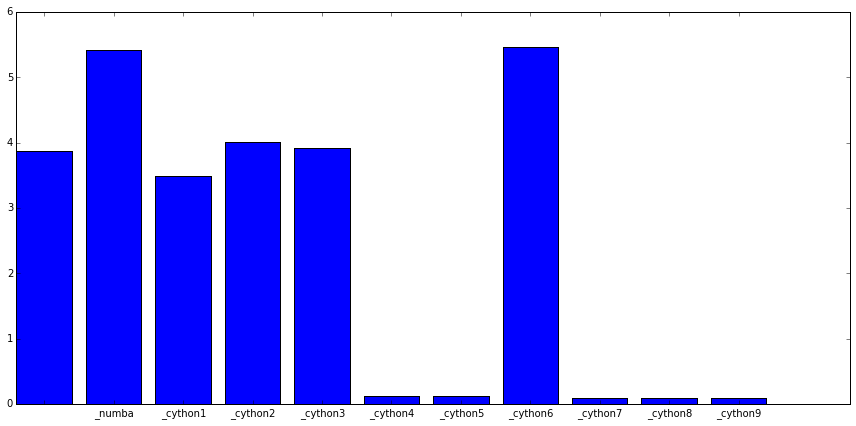

In [94]:
index = np.arange(len(t))
plt.figure(figsize = (12, 6))
plt.bar(index, t)
plt.xticks(index + 0.4, [func.__name__[9:] for func in funcs])
plt.tight_layout()

En el gráfico anterior, la primera barra corresponde a la función de partida (`busca_min`).

Y ahora vamos a ver los tiempos entre `busca_min` (la versión original) y la última versión de cython que hemos creado, `busca_min_cython9` usando diferentes tamaños de la matriz de entrada:

In [95]:
tamanyos = [10, 100, 500, 1000, 2000, 5000]
t_p = []
t_c = []
for i in tamanyos:
    data = np.random.randn(i, i)
    res = %timeit -o busca_min(data)
    t_p.append(res.best)
    res = %timeit -o busca_min_cython9(data)
    t_c.append(res.best)

10000 loops, best of 3: 64.4 µs per loop
The slowest run took 4.71 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 4.88 µs per loop
100 loops, best of 3: 9.16 ms per loop
10000 loops, best of 3: 195 µs per loop
1 loops, best of 3: 234 ms per loop
100 loops, best of 3: 5.21 ms per loop
1 loops, best of 3: 955 ms per loop
10 loops, best of 3: 21.6 ms per loop
1 loops, best of 3: 3.82 s per loop
10 loops, best of 3: 87.7 ms per loop
1 loops, best of 3: 24.4 s per loop
1 loops, best of 3: 574 ms per loop


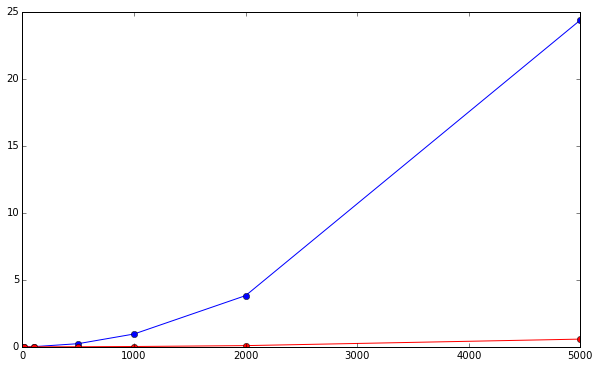

In [96]:
plt.figure(figsize = (10,6))
plt.plot(tamanyos, t_p, 'bo-')
plt.plot(tamanyos, t_c, 'ro-')

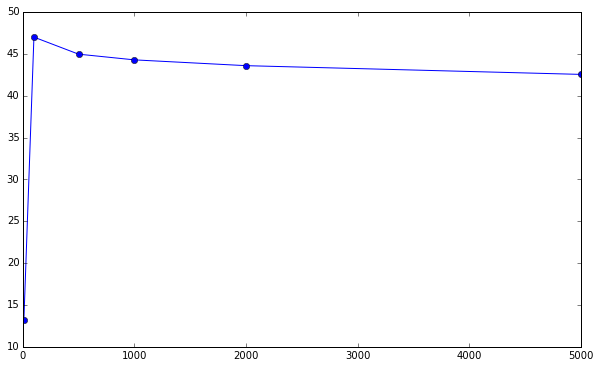

In [97]:
ratio = np.array(t_p) / np.array(t_c)
plt.figure(figsize = (10,6))
plt.plot(tamanyos, ratio, 'bo-')

Parece que conseguimos rendimientos que son 40 veces más rápidos que con Python puro que usa un numpy array de por medio (excepto para tamaños de arrays muy pequeños en los que el rendimiento no sería una gran problema).

tamanyos

[24.356527847999814]